In [5]:
import time
import requests
import pandas as pd

API_KEY = "op://khrustal/api.um.warszawa.pl/Section_j3dttihdrs6or7g7eztj2zaeuq/api_key"

# Интервал между запросами в секундах – чтобы не превышать 1 запрос/сек 
REQUEST_INTERVAL = 0.2

def do_safe_request(url, wait=REQUEST_INTERVAL):
    """Делает GET-запрос и возвращает resp.json(), ожидая `wait` секунд после каждого запроса."""
    resp = requests.get(url)
    data = resp.json()  # В реальном проекте желательно ещё проверять resp.status_code
    time.sleep(wait)
    return data

def get_stop_coordinates_page(page=1, size=1000, api_key=APIKEY, resource_id='ab75c33d-3a26-4342-b36a-6e5fef0a3ac3'):
    """Запрос одной страницы данных о координатах."""
    url = (
        f"https://api.um.warszawa.pl/api/action/dbstore_get"
        f"?id={resource_id}"
        f"&page={page}"
        f"&size={size}"
        f"&apikey={api_key}"
    )
    data_json = do_safe_request(url)
    return data_json

def get_stop_coordinates_all(api_key=APIKEY, resource_id='ab75c33d-3a26-4342-b36a-6e5fef0a3ac3',
                             max_pages=5, page_size=1000):
    """Проходит по страницам, выгружая все координаты остановок (ограничение: max_pages)."""
    all_records = []
    for page in range(1, max_pages + 1):
        data_page = get_stop_coordinates_page(page, page_size, api_key, resource_id)
        result = data_page.get("result", [])
        if not result:
            print(f"Страница {page} вернула пустой список – завершаем выгрузку.")
            break
        all_records.extend(result)
    return all_records

def parse_coords_item(item):
    # item = {"values": [{"key":"...", "value":"..."}, ...]}
    row_dict = {}
    for kv in item.get("values", []):
        row_dict[kv["key"]] = kv["value"]
    return row_dict


# Пример использования: выкачиваем часть координат и собираем в DataFrame

In [6]:
coords_data = get_stop_coordinates_all(max_pages=3, page_size=50)  # Для примера, не более 3 страниц по 50 записей
coords_parsed = [parse_coords_item(elem) for elem in coords_data]
df_coords = pd.DataFrame(coords_parsed)
print("Скачано записей об остановках:", len(df_coords))
display(df_coords.head(10))

Скачано записей об остановках: 24438


,zespol,slupek,nazwa_zespolu,id_ulicy,szer_geo,dlug_geo,kierunek,obowiazuje_od
0,1001,01,Kijowska,2201,52.248455,21.044827,al.Zieleniecka,2025-01-27 00:00:00.0
1,1001,02,Kijowska,2201,52.249078,21.044443,Ząbkowska,2025-01-27 00:00:00.0
2,1001,03,Kijowska,2201,52.248928,21.044169,al.Zieleniecka,2025-01-27 00:00:00.0
3,1001,04,Kijowska,2201,52.249969,21.041588,Ząbkowska,2025-01-27 00:00:00.0
4,1001,05,Kijowska,1203,52.250319,21.043861,al.Zieleniecka,2025-01-27 00:00:00.0
5,1001,06,Kijowska,1203,52.250078,21.043848,Dw.Wschodni (Kijowska),2025-01-27 00:00:00.0
6,1001,07,Kijowska,1203,52.250228,21.043690,Ząbkowska,2025-01-27 00:00:00.0
7,1001,08,Kijowska,1203,52.249944,21.044087,Dw.Wschodni (Kijowska),2025-01-27 00:00:00.0
8,1001,88,Kijowska,1203,52.249944,21.044087,Dw.Wschodni (Kijowska),2025-01-27 00:00:00.0
9,1002,01,Ząbkowska,2201,52.251325,21.038457,Kijowska,2025-01-27 00:00:00.0


# Аналогично поступаем при запросах расписаний:

In [13]:

def get_lines_for_stop(busstop_id, busstop_nr, api_key=APIKEY):
    """
    Возвращает список { 'linia': XXX }, используя
    id=88cd555f-6f31-43ca-9de4-66c479ad5942
    """
    url = (
        "https://api.um.warszawa.pl/api/action/dbtimetable_get"
        f"?id=88cd555f-6f31-43ca-9de4-66c479ad5942"
        f"&busstopId={busstop_id}"
        f"&busstopNr={busstop_nr}"
        f"&apikey={api_key}"
    )
    data_json = do_safe_request(url)
    lines = []
    
    result = data_json.get("result", [])
    
    # Проверяем, что result не пустой
    if not result:
        return lines
    
    # Обрабатываем разные возможные структуры ответа
    for item in result:
        # Если item - это словарь с ключом "values"
        if isinstance(item, dict) and "values" in item:
            for kv in item["values"]:
                if isinstance(kv, dict) and "key" in kv and "value" in kv and kv["key"] == "linia":
                    lines.append({"linia": kv["value"]})
        
        # Если item - это список (например, список key-value пар)
        elif isinstance(item, list):
            for kv in item:
                if isinstance(kv, dict) and "key" in kv and "value" in kv and kv["key"] == "linia":
                    lines.append({"linia": kv["value"]})
    
    return lines

def get_timetable_for_line(busstop_id, busstop_nr, line, api_key=APIKEY):
    """
    Возвращает расписание для (busstopId, busstopNr, line),
    используя id=e923fa0e-d96c-43f9-ae6e-60518c9f3238.
    """
    url = (
        "https://api.um.warszawa.pl/api/action/dbtimetable_get"
        f"?id=e923fa0e-d96c-43f9-ae6e-60518c9f3238"
        f"&busstopId={busstop_id}"
        f"&busstopNr={busstop_nr}"
        f"&line={line}"
        f"&apikey={api_key}"
    )
    data_json = do_safe_request(url)
    out = []
    
    result = data_json.get("result", [])
    
    # Проверяем, что result не пустой
    if not result:
        return out
    
    # Обрабатываем разные возможные структуры ответа
    for item in result:
        record = {}
        
        # Если item - это словарь с ключом "values"
        if isinstance(item, dict) and "values" in item:
            for kv in item["values"]:
                if isinstance(kv, dict) and "key" in kv and "value" in kv:
                    record[kv["key"]] = kv["value"]
        
        # Если item - это список (например, список key-value пар)
        elif isinstance(item, list):
            for kv in item:
                if isinstance(kv, dict) and "key" in kv and "value" in kv:
                    record[kv["key"]] = kv["value"]
        
        # Пропускаем строки и другие типы данных
        
        if record:  # Добавляем только если удалось извлечь какие-то данные
            out.append(record)
    
    return out



# Сквозной пример: получаем линии и расписания для 5 остановок.

In [14]:

all_timetables = []
for i, row in df_coords.head(5).iterrows():
    busstop_id = row.get("zespol")
    busstop_nr = row.get("slupek")
    nazwa = row.get("nazwa_zespolu", "")

    if not busstop_id or not busstop_nr:
        continue

    # Узнаём, какие линии ходят
    lines_data = get_lines_for_stop(busstop_id, busstop_nr)
    
    for line_info in lines_data:
        line_num = line_info["linia"]
        # Берём расписание
        timetable = get_timetable_for_line(busstop_id, busstop_nr, line_num)
        for t in timetable:
            all_timetables.append({
                "zespol": busstop_id,
                "slupek": busstop_nr,
                "nazwa_zespolu": nazwa,
                "linia": line_num,
                "czas": t.get("czas"),
                "kierunek": t.get("kierunek"),
                "trasa": t.get("trasa"),
                "brygada": t.get("brygada"),
            })

df_timetables = pd.DataFrame(all_timetables)
print("Количество строк расписаний (пример):", len(df_timetables))
display(df_timetables.head(20))


###############################################################################
# Итог: после каждого запроса скрипт ждет REQUEST_INTERVAL=1.0 секунду.
# При желании – поменяйте значение REQUEST_INTERVAL на большее или меньшее.
###############################################################################

Количество строк расписаний (пример): 2129


,zespol,slupek,nazwa_zespolu,linia,czas,kierunek,trasa,brygada
0,1001,01,Kijowska,146,17:00:00,Dw. Wschodni (Lubelska),TP-DWL,1
1,1001,01,Kijowska,146,19:27:00,Dw. Wschodni (Lubelska),TP-DWL,06
2,1001,01,Kijowska,146,23:32:00,Dw. Wschodni (Lubelska),TP-DWL,1
3,1001,01,Kijowska,146,12:06:00,Dw. Wschodni (Lubelska),TP-DWL,5
4,1001,01,Kijowska,146,18:14:00,Dw. Wschodni (Lubelska),TP-DWL,3
5,1001,01,Kijowska,146,07:32:00,Dw. Wschodni (Lubelska),TP-DWL,5
6,1001,01,Kijowska,146,05:32:00,Dw. Wschodni (Lubelska),TP-DWL,09
7,1001,01,Kijowska,146,05:55:00,Dw. Wschodni (Lubelska),TP-DWL,06
8,1001,01,Kijowska,146,13:06:00,Dw. Wschodni (Lubelska),TP-DWL,2
9,1001,01,Kijowska,146,19:47:00,Dw. Wschodni (Lubelska),TP-DWL,2


In [15]:
print("df_coords DataFrame:")
print("Shape:", df_coords.shape)
print("\nColumns:")
for col in df_coords.columns:
    print(f"- {col}: {df_coords[col].dtype}")
print("\nSample rows:")
display(df_coords.head(3))

print("\n" + "="*80 + "\n")

print("df_timetables DataFrame:") 
print("Shape:", df_timetables.shape)
print("\nColumns:")
for col in df_timetables.columns:
    print(f"- {col}: {df_timetables[col].dtype}")
print("\nSample rows:")
display(df_timetables.head(3))


df_coords DataFrame:
Shape: (24438, 8)

Columns:
- zespol: object
- slupek: object
- nazwa_zespolu: object
- id_ulicy: object
- szer_geo: object
- dlug_geo: object
- kierunek: object
- obowiazuje_od: object

Sample rows:


,zespol,slupek,nazwa_zespolu,id_ulicy,szer_geo,dlug_geo,kierunek,obowiazuje_od
0,1001,01,Kijowska,2201,52.248455,21.044827,al.Zieleniecka,2025-01-27 00:00:00.0
1,1001,02,Kijowska,2201,52.249078,21.044443,Ząbkowska,2025-01-27 00:00:00.0
2,1001,03,Kijowska,2201,52.248928,21.044169,al.Zieleniecka,2025-01-27 00:00:00.0




df_timetables DataFrame:
Shape: (2129, 8)

Columns:
- zespol: object
- slupek: object
- nazwa_zespolu: object
- linia: object
- czas: object
- kierunek: object
- trasa: object
- brygada: object

Sample rows:


,zespol,slupek,nazwa_zespolu,linia,czas,kierunek,trasa,brygada
0,1001,01,Kijowska,146,17:00:00,Dw. Wschodni (Lubelska),TP-DWL,1
1,1001,01,Kijowska,146,19:27:00,Dw. Wschodni (Lubelska),TP-DWL,06
2,1001,01,Kijowska,146,23:32:00,Dw. Wschodni (Lubelska),TP-DWL,1


In [16]:
df_coords_renamed = df_coords.rename(columns={
    "zespol": "busstop_id",
    "slupek": "busstop_nr",
    "nazwa_zespolu": "busstop_name",
    "id_ulicy": "street_id",
    "szer_geo": "latitude",
    "dlug_geo": "longitude",
    "kierunek": "direction",
    "obowiazuje_od": "valid_from",
})
df_timetables_renamed = df_timetables.rename(columns={
    "zespol": "busstop_id",
    "slupek": "busstop_nr",
    "nazwa_zespolu": "busstop_name",
    "linia": "line",
    "czas": "time",
    "kierunek": "direction",
    "trasa": "route",
    "brygada": "brigade",
})


# Оценка суммарного количества отправлений (рейсов) в сутки для каждого busstop_id

In [17]:
# Определяем количество групп остановок для анализа (ограничиваем для примера)
MAX_ZESPOL = 20  # Для примера — обработаем 20 групп, можно увеличить или задать None для всех

def get_timetable_count(busstop_id, busstop_nr, line, api_key=APIKEY):
    """
    Возвращает число записей (строк) в расписании, т.е. количество отправлений
    для (busstop_id, busstop_nr, line) за сутки, в ОДНУ сторону.
    """
    url = (
        "https://api.um.warszawa.pl/api/action/dbtimetable_get"
        f"?id=e923fa0e-d96c-43f9-ae6e-60518c9f3238"
        f"&busstopId={busstop_id}"
        f"&busstopNr={busstop_nr}"
        f"&line={line}"
        f"&apikey={api_key}"
    )
    data_json = do_safe_request(url)
    
    # Извлекаем результат и считаем количество записей
    result = data_json.get("result", [])
    # Пустая проверка на случай, если result - не список
    if not isinstance(result, list):
        return 0
    return len(result)

# 1. Группируем все slupek по busstop_id (zespol)
grouped_slupki = df_coords_renamed.groupby("busstop_id")["busstop_nr"].apply(list).reset_index(name="all_slupki")

# Присоединяем название остановки (busstop_name)
busstop_names = df_coords_renamed.groupby("busstop_id")["busstop_name"].agg(lambda x: x.mode()[0] if len(x.mode())>0 else "").reset_index()
df_zespoly = pd.merge(grouped_slupki, busstop_names, on="busstop_id", how="left")

# 2. Берём (для примера) первые MAX_ZESPOL групп (или все, если None)
if MAX_ZESPOL is not None:
    df_zespoly = df_zespoly.head(MAX_ZESPOL)

print(f"Анализируем {len(df_zespoly)} групп остановок...")

results = []
for idx, row in df_zespoly.iterrows():
    busstop_id = row["busstop_id"]      # e.g. "1001"
    busstop_name = row["busstop_name"]  # e.g. "Kijowska"
    slupki_list = row["all_slupki"]     # e.g. ["01","02","03"...]
    
    print(f"Обрабатываем {busstop_id} - {busstop_name} ({len(slupki_list)} slupek)")
    
    # Собираем все линии, которые ходят по всем slupek в данном busstop_id
    all_lines_set = set()
    for slupek in slupki_list:
        lines_data = get_lines_for_stop(busstop_id, slupek)
        # Извлекаем номера линий из данных
        lines = [line_info["linia"] for line_info in lines_data]
        all_lines_set.update(lines)  # добавляем к общему набору
    
    total_departures = 0
    lines_details = []
    
    for line in sorted(all_lines_set):
        # Ищем любой slupek, где эта line появляется
        chosen_slupek = None
        for s in slupki_list:
            lines_here = get_lines_for_stop(busstop_id, s)
            lines_nums = [line_info["linia"] for line_info in lines_here]
            if line in lines_nums:
                chosen_slupek = s
                break
        
        if chosen_slupek is None:
            # хотя не должно случиться, т.к. line точно где-то в slupki_list
            continue
        
        # Получаем кол-во записей
        count_for_line = get_timetable_count(busstop_id, chosen_slupek, line)
        total_departures += count_for_line
        
        lines_details.append({
            "line": line,
            "slupek": chosen_slupek,
            "departures": count_for_line
        })
    
    results.append({
        "busstop_id": busstop_id,
        "busstop_name": busstop_name,
        "slupki_count": len(slupki_list),
        "lines_count": len(all_lines_set),
        "daily_departures": total_departures,
        "lines_details": lines_details
    })
    
    print(f"  Найдено {len(all_lines_set)} линий, всего {total_departures} отправлений в день")

df_estimates = pd.DataFrame([{k: v for k, v in r.items() if k != 'lines_details'} for r in results])
df_estimates = df_estimates.sort_values("daily_departures", ascending=False)

print("\nТоп групп остановок по количеству отправлений:")
display(df_estimates.head(10))



Анализируем 20 групп остановок...
Обрабатываем 1001 - Kijowska (27 slupek)
  Найдено 29 линий, всего 1649 отправлений в день
Обрабатываем 1002 - Ząbkowska (15 slupek)
  Найдено 24 линий, всего 1187 отправлений в день
Обрабатываем 1003 - Dw.Wileński (51 slupek)
  Найдено 31 линий, всего 1682 отправлений в день
Обрабатываем 1004 - Ratuszowa-ZOO (24 slupek)
  Найдено 6 линий, всего 327 отправлений в день
Обрабатываем 1005 - pl.Hallera (39 slupek)
  Найдено 13 линий, всего 648 отправлений в день
Обрабатываем 1006 - rondo Starzyńskiego (33 slupek)
  Найдено 12 линий, всего 1032 отправлений в день
Обрабатываем 1007 - Golędzinów (12 slupek)
  Найдено 4 линий, всего 366 отправлений в день
Обрабатываем 1008 - PIMot (12 slupek)
  Найдено 4 линий, всего 366 отправлений в день
Обрабатываем 1009 - Batalionu Platerówek (12 slupek)
  Найдено 2 линий, всего 216 отправлений в день
Обрабатываем 1010 - Śliwice (12 slupek)
  Найдено 4 линий, всего 366 отправлений в день
Обрабатываем 1011 - Budzińskiej-Tyl

,busstop_id,busstop_name,slupki_count,lines_count,daily_departures
2,1003,Dw.Wileński,51,31,1682
0,1001,Kijowska,27,29,1649
12,1013,Żerań FSO,42,18,1251
1,1002,Ząbkowska,15,24,1187
5,1006,rondo Starzyńskiego,33,12,1032
19,1020,Białołęka-Ratusz,9,13,713
15,1016,Konwaliowa,9,14,676
16,1017,Płochocińska,9,15,656
4,1005,pl.Hallera,39,13,648
17,1018,Ekspresowa,9,11,554


ModuleNotFoundError: No module named 'matplotlib'

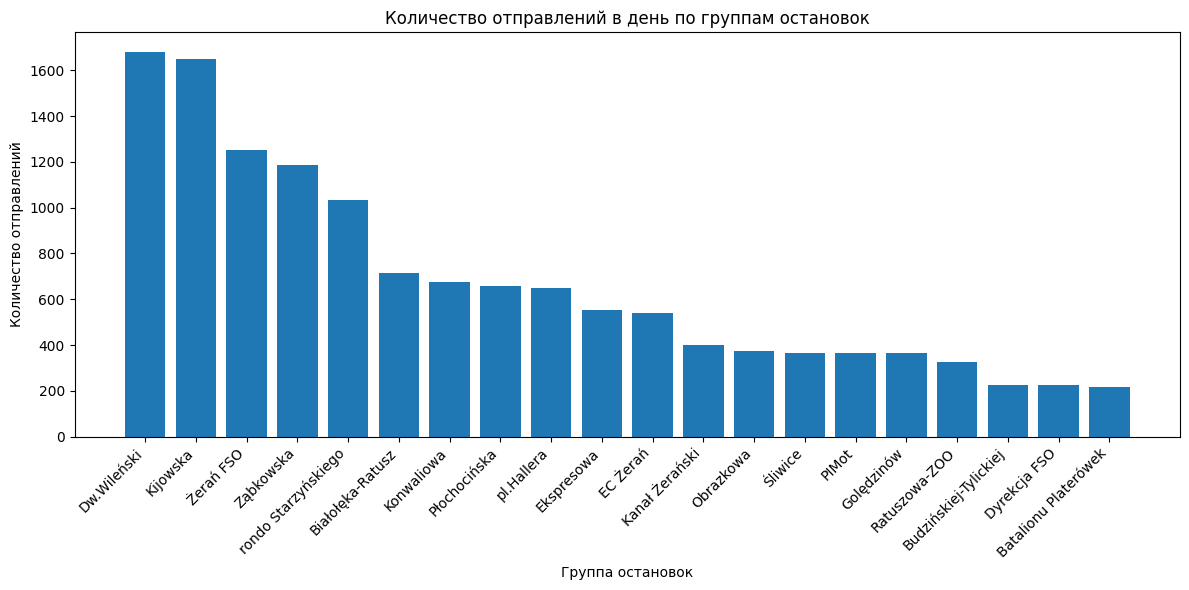

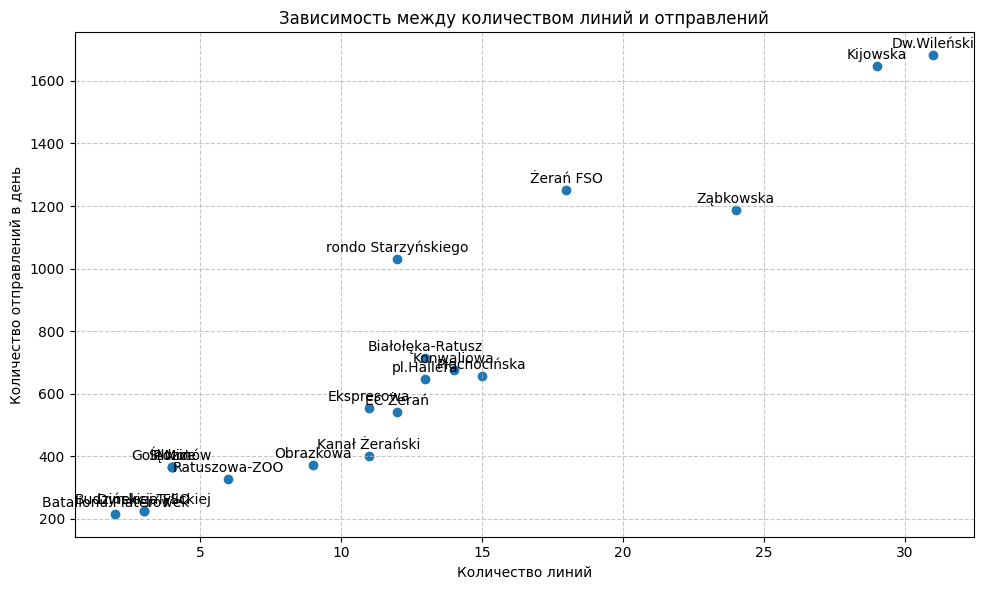

In [18]:
# Визуализация результатов
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(df_estimates['busstop_name'], df_estimates['daily_departures'])
plt.xticks(rotation=45, ha='right')
plt.title('Количество отправлений в день по группам остановок')
plt.xlabel('Группа остановок')
plt.ylabel('Количество отправлений')
plt.tight_layout()
plt.show()

# Дополнительная визуализация: соотношение линий и отправлений
plt.figure(figsize=(10, 6))
plt.scatter(df_estimates['lines_count'], df_estimates['daily_departures'])
for i, row in df_estimates.iterrows():
    plt.annotate(row['busstop_name'], 
                 (row['lines_count'], row['daily_departures']),
                 textcoords="offset points", 
                 xytext=(0,5), 
                 ha='center')

plt.title('Зависимость между количеством линий и отправлений')
plt.xlabel('Количество линий')
plt.ylabel('Количество отправлений в день')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Более детальный анализ отдельных остановок

Детальный анализ остановки Kijowska (ID: 1001)
Всего направлений (slupki): 27
Всего линий: 29
Всего отправлений в день: 1649

Топ 10 самых частых линий:


,line,slupek,departures
20,509,01,116
17,26,03,114
19,3,03,107
18,28,04,106
22,6,03,106
23,7,03,99
16,25,03,92
5,13,04,90
21,512,07,72
7,138,01,67


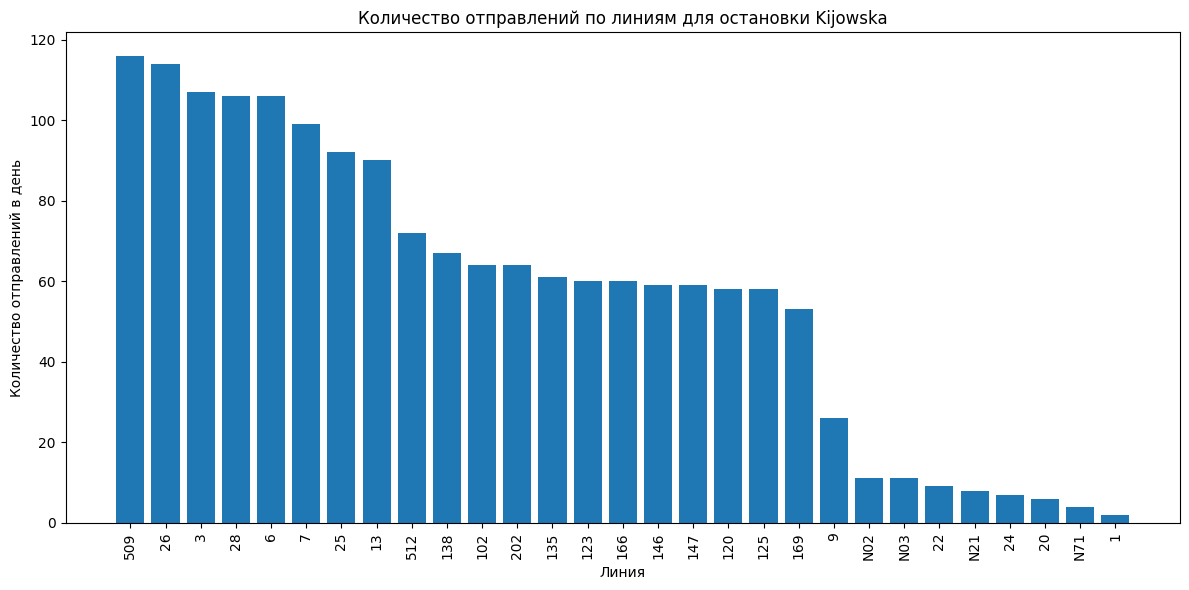


Распределение отправлений по линиям:


,line,departures,percent,cumulative_percent
20,509,116,7.0,7.0
17,26,114,6.9,13.9
19,3,107,6.5,20.4
18,28,106,6.4,26.9
22,6,106,6.4,33.3
23,7,99,6.0,39.3
16,25,92,5.6,44.9
5,13,90,5.5,50.3
21,512,72,4.4,54.7
7,138,67,4.1,58.8


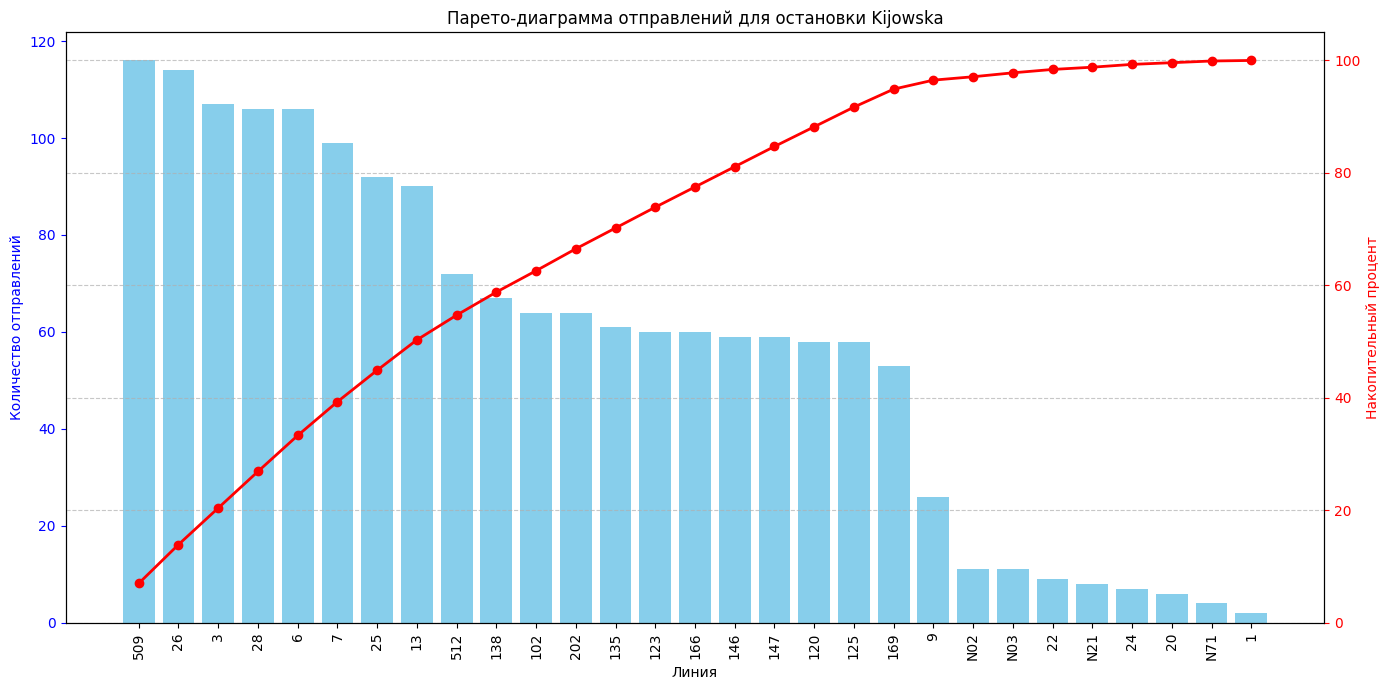

In [19]:
# Анализ распределения линий по отправлениям для выбранной остановки
if len(results) > 0:
    # Берем самую загруженную остановку или можно выбрать индекс вручную
    busiest_stop_idx = 0  # Индекс самой загруженной остановки в results
    busiest_stop = results[busiest_stop_idx]
    
    print(f"Детальный анализ остановки {busiest_stop['busstop_name']} (ID: {busiest_stop['busstop_id']})")
    print(f"Всего направлений (slupki): {busiest_stop['slupki_count']}")
    print(f"Всего линий: {busiest_stop['lines_count']}")
    print(f"Всего отправлений в день: {busiest_stop['daily_departures']}")
    
    # Создаем DataFrame для линий
    df_lines = pd.DataFrame(busiest_stop['lines_details'])
    df_lines = df_lines.sort_values('departures', ascending=False)
    
    print("\nТоп 10 самых частых линий:")
    display(df_lines.head(10))
    
    # Визуализация распределения отправлений по линиям
    plt.figure(figsize=(12, 6))
    plt.bar(df_lines['line'], df_lines['departures'])
    plt.xticks(rotation=90)
    plt.title(f'Количество отправлений по линиям для остановки {busiest_stop["busstop_name"]}')
    plt.xlabel('Линия')
    plt.ylabel('Количество отправлений в день')
    plt.tight_layout()
    plt.show()
    
    # Анализ распределения отправлений
    total_deps = df_lines['departures'].sum()
    cumulative_percent = (df_lines['departures'].cumsum() / total_deps * 100).round(1)
    df_lines['percent'] = (df_lines['departures'] / total_deps * 100).round(1)
    df_lines['cumulative_percent'] = cumulative_percent
    
    print("\nРаспределение отправлений по линиям:")
    display(df_lines[['line', 'departures', 'percent', 'cumulative_percent']].head(10))
    
    # Парето-диаграмма
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.bar(df_lines['line'], df_lines['departures'], color='skyblue')
    ax1.set_xlabel('Линия')
    ax1.set_ylabel('Количество отправлений', color='blue')
    ax1.tick_params(axis='y', colors='blue')
    plt.xticks(rotation=90)
    
    ax2 = ax1.twinx()
    ax2.plot(df_lines['line'], df_lines['cumulative_percent'], 'r-', marker='o', linewidth=2)
    ax2.set_ylabel('Накопительный процент', color='red')
    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylim([0, 105])
    
    plt.title(f'Парето-диаграмма отправлений для остановки {busiest_stop["busstop_name"]}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [39]:
import sys
import pkg_resources
print(f"Python version: {sys.version}")
print(f"nbformat version: {pkg_resources.get_distribution('nbformat').version}")

Python version: 3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]
nbformat version: 5.10.4


In [42]:
!pip install --upgrade plotly


  Using cached plotly-6.0.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached narwhals-1.30.0-py3-none-any.whl.metadata (11 kB)
Using cached plotly-6.0.0-py3-none-any.whl (14.8 MB)
Using cached narwhals-1.30.0-py3-none-any.whl (313 kB)


In [46]:
import plotly.io as pio
#pio.renderers.default = "browser"
# pio.renderers.default = "notebook_connected"
fig = px.scatter(
    df_estimates,
    x="lines_count",              # заменяем на реальное имя столбца
    y="daily_departures",         # заменяем на реальное имя столбца
    color="lines_count",          # для цветового оформления
    size="daily_departures",      # размер точек пропорционален количеству отправлений
    hover_name="busstop_name",    # при наведении показываем название остановки
    hover_data=["lines_count", "daily_departures"],
    color_continuous_scale=px.colors.sequential.Viridis,
    title="Number of Lines vs. Daily Departures"
)

fig.update_layout(
    xaxis_title="Количество линий",
    yaxis_title="Количество отправлений в день"
)

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [53]:
import pandas as pd

# Предполагаем, что у вас уже есть DataFrame df_coords с колонками:
# ['zespol', 'slupek', 'nazwa_zespolu', 'id_ulicy', 'szer_geo', 'dlug_geo', 'kierunek', 'obowiazuje_od']

# Оставляем только записи с slupek == "01"
df_locations = df_coords[df_coords['slupek'] == "01"].copy()

# Выбираем нужные колонки и переименовываем их:
# Drop duplicate rows to get only distinct locations
df_locations = df_locations.drop_duplicates()

df_locations = df_locations[['zespol', 'nazwa_zespolu', 'szer_geo', 'dlug_geo']].copy()
df_locations.rename(columns={
    'zespol': 'id',
    'nazwa_zespolu': 'name',
    'szer_geo': 'lat',
    'dlug_geo': 'lng'
}, inplace=True)

# Сохраняем в CSV
df_locations.to_csv("locations.csv", index=False)
print("locations.csv создан.")


locations.csv создан.


In [ ]:
# -------------------------------
# 1. Создание locations.csv
# -------------------------------

# Предполагаем, что df_coords уже загружен и имеет столбцы:
# ['zespol', 'slupek', 'nazwa_zespolu', 'id_ulicy', 'szer_geo', 'dlug_geo', 'kierunek', 'obowiazuje_od']

# Оставляем только записи с slupek == "01"
df_locations = df_coords[df_coords['slupek'] == "01"].copy()

# Выбираем нужные колонки и переименовываем их:
df_locations = df_locations[['zespol', 'nazwa_zespolu', 'szer_geo', 'dlug_geo']].copy()
df_locations.rename(columns={
    'zespol': 'id',
    'nazwa_zespolu': 'name',
    'szer_geo': 'lat',
    'dlug_geo': 'lng'
}, inplace=True)

# Сохраняем locations.csv
df_locations.to_csv("locations.csv", index=False)
print("locations.csv создан.")



In [54]:
import pandas as pd
import json
from datetime import datetime, timedelta
import time

# -------------------------------
# 2. Загрузка официального порядка остановок
# -------------------------------

# Предположим, что файл public_transport_routes.json содержит ответ API,
# приведённый в вашем примере.
with open("data\public_transport_routes.json", encoding="utf-8") as f:
    routes_data = json.load(f)

# routes_data имеет структуру: { "result": { <route_key>: { <variant>: { <order_key>: { ... } } } } }
# Мы построим словарь, в котором для каждой линии (например, "L51" или "217") берется порядок остановок
# из первого варианта (например, первый ключ в словаре вариантов).
# Для каждого стопа нас интересует "nr_zespolu", который мы будем сопоставлять с нашим df_timetables (поле zespol).

route_orderings = {}  # { line: [stop1, stop2, ...] }
result = routes_data.get("result", {})

for line_key, variants in result.items():
    # variants – это словарь, где ключи могут быть, например, "TP-ORL", "TP-OWR" и т.д.
    # Выберем первый вариант.
    if isinstance(variants, dict) and variants:
        first_variant_key = next(iter(variants))
        stops_dict = variants[first_variant_key]  # stops_dict: ключи как порядковые номера ("1", "2", "3", ...) 
        # Отсортируем по порядковому номеру (преобразуя ключи к int)
        try:
            sorted_stops = sorted(stops_dict.items(), key=lambda kv: int(kv[0]))
        except Exception as e:
            sorted_stops = sorted(stops_dict.items())
        # Извлекаем для каждого записи значение "nr_zespolu"
        ordering = [stop_info.get("nr_zespolu") for order_key, stop_info in sorted_stops]
        route_orderings[line_key] = ordering

# Пример: распечатать порядок для одной линии (если есть)
if route_orderings:
    sample_line = next(iter(route_orderings))
    print(f"Порядок остановок для линии {sample_line}: {route_orderings[sample_line]}")

# -------------------------------
# 3. Создание flows.csv
# -------------------------------

# Для flows нам нужен агрегат по отправлениям по часам.
# В df_timetables, время указано в поле "czas" (формат "HH:MM:SS", с возможным "24:02:00" и т.п.).
# Будем использовать базовую дату для преобразования времени.
base_date = datetime(2025, 1, 27)

# Функция для корректного парсинга времени, учитывающая значения >= 24 часов.
def parse_departure_time(time_str, base_date):
    parts = time_str.split(":")
    hour = int(parts[0])
    minute = int(parts[1])
    second = int(parts[2])
    if hour >= 24:
        hour -= 24
        base_date = base_date + timedelta(days=1)
    return base_date.replace(hour=hour, minute=minute, second=second)

# Преобразуем 'czas' в datetime и извлекаем час
df_timetables['departure_datetime'] = df_timetables['czas'].apply(
    lambda t: parse_departure_time(t, base_date)
)
df_timetables['hour'] = df_timetables['departure_datetime'].dt.hour

# Агрегируем данные: считаем количество отправлений для каждой комбинации (zespol, linia, hour).
agg = df_timetables.groupby(['zespol', 'linia', 'hour']).size().reset_index(name='count')
agg.rename(columns={'zespol': 'busstop_id', 'linia': 'line'}, inplace=True)

# Теперь для каждой линии мы будем использовать официальный порядок остановок, если он есть.
flows_list = []
# Группируем агрегированные данные по линии и по busstop_id (origin)
for line, group in agg.groupby('line'):
    # Определяем официальный порядок остановок для этой линии.
    # Если официального порядка нет для данной линии, можно пропустить или использовать сортировку по busstop_id.
    if line in route_orderings:
        official_order = route_orderings[line]
    else:
        # Если порядок не найден, используем отсортированные по числовому значению busstop_id.
        official_order = sorted(group['busstop_id'].unique(), key=lambda x: int(x))
    
    # Для каждой пары последовательных остановок в official_order
    for i in range(len(official_order) - 1):
        origin = official_order[i]
        dest = official_order[i+1]
        # Для каждого часа берём данные по origin для данной линии.
        origin_data = group[group['busstop_id'] == origin]
        for _, row in origin_data.iterrows():
            hr = row['hour']
            cnt = row['count']
# with this:
            dt = base_date + timedelta(hours=hr)
            dt_str = dt.strftime("%Y-%m-%d %H:%M:%S")  # formatted datetime string
            flows_list.append({
                'origin': origin,
                'dest': dest,
                'line': line,
                'count': cnt,
                'time': dt_str
            })
            
df_flows = pd.DataFrame(flows_list)
df_flows.to_csv("flows.csv", index=False)
print("flows.csv создан.")


locations.csv создан.
Порядок остановок для линии L51: ['2868', '2865', '2864', '2862', '2870', '2360', '2869', '2869', '2242', '2237', '2239', '2358']
flows.csv создан.


<>:35: SyntaxWarning:

invalid escape sequence '\p'

<>:35: SyntaxWarning:

invalid escape sequence '\p'

C:\Users\nkhrustalev\AppData\Local\Temp\ipykernel_28860\1929349443.py:35: SyntaxWarning:

invalid escape sequence '\p'



In [56]:
# Get distinct counts for each column
print("Number of distinct values in each column:")
print(f"zespol (busstop_id): {coords_parsed['zespol'].nunique()}")
print(f"slupek (stop_id): {coords_parsed['slupek'].nunique()}")
print(f"nazwa_zespolu (busstop_name): {coords_parsed['nazwa_zespolu'].nunique()}")
print(f"id_ulicy (street_id): {coords_parsed['id_ulicy'].nunique()}")
print(f"kierunek (direction): {coords_parsed['kierunek'].nunique()}")


Number of distinct values in each column:


TypeError: list indices must be integers or slices, not str

In [59]:
# Get count of unique combinations of busstop_id, busstop_nr and line
unique_combinations = df_coords_renamed.groupby(['busstop_id', 'busstop_nr', 'line']).size().reset_index()
print(f"Number of unique combinations of busstop_id, busstop_nr and line: {len(unique_combinations)}")


KeyError: 'line'

In [68]:
df_estimates.head()

,busstop_id,busstop_name,slupki_count,lines_count,daily_departures
2,1003,Dw.Wileński,51,31,1682
0,1001,Kijowska,27,29,1649
12,1013,Żerań FSO,42,18,1251
1,1002,Ząbkowska,15,24,1187
5,1006,rondo Starzyńskiego,33,12,1032


In [69]:
df_locations.head()

,id,name,lat,lng
0,1001,Kijowska,52.248455,21.044827
9,1002,Ząbkowska,52.251325,21.038457
14,1003,Dw.Wileński,52.253739,21.035454
31,1004,Ratuszowa-ZOO,52.256614,21.028536
39,1005,pl.Hallera,52.258094,21.027097


In [79]:
# Perform a left join between df_estimates and df_locations
# Joining on df_estimates.busstop_id = df_locations.id
# Only keeping the lat and lng fields from df_locations
df_estimations_joined = pd.merge(
    df_estimates,
    df_locations[['id', 'lat', 'lng']],
    left_on='busstop_id',
    right_on='id',
    how='left'
).drop('id', axis=1).drop_duplicates()



In [80]:
df_estimations_joined.head()


,busstop_id,busstop_name,slupki_count,lines_count,daily_departures,lat,lng
0,1003,Dw.Wileński,51,31,1682,52.253739,21.035454
1,1003,Dw.Wileński,51,31,1682,52.253739,21.035454
2,1003,Dw.Wileński,51,31,1682,52.253739,21.035454
3,1001,Kijowska,27,29,1649,52.248455,21.044827
4,1001,Kijowska,27,29,1649,52.248455,21.044827


In [ ]:
import sys
print(sys.executable)
!{sys.executable} -m pip install folium


In [94]:

# Import necessary libraries for plotting on a map
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

# Ensure lat and lng are numeric
df_estimations_joined['lat'] = pd.to_numeric(df_estimations_joined['lat'])
df_estimations_joined['lng'] = pd.to_numeric(df_estimations_joined['lng'])
# Remove duplicate rows to avoid multiple markers at the same location
df_unique = df_estimations_joined.drop_duplicates(subset=['busstop_id'])[['busstop_id', 'busstop_name', 'slupki_count', 'lines_count', 'daily_departures', 'lat', 'lng']]
# Create a base map centered around Warsaw
map_center = [df_unique['lat'].mean(), df_unique['lng'].mean()]
mymap = folium.Map(location=map_center, zoom_start=12)

# Add a marker cluster to make the map more readable
marker_cluster = MarkerCluster().add_to(mymap)

# Calculate size scaling factor for bubbles (adjust as needed)
max_departures = df_unique['daily_departures'].max()
scale_factor = 50  # Adjust this value to change the overall size of bubbles

# Add markers for each bus stop
# Instead of using MarkerCluster, add markers directly to the map
for idx, row in df_unique.iterrows():
    # Calculate marker size based on daily_departures
    size = (row['daily_departures'] / max_departures) * scale_factor
    
    # Create popup text with information about the bus stop
    popup_text = f"""
    <b>{row['busstop_name']}</b><br>
    Bus Stop ID: {row['busstop_id']}<br>
    Number of Stops: {row['slupki_count']}<br>
    Number of Lines: {row['lines_count']}<br>
    Daily Departures: {row['daily_departures']}
    """
    
    # Add circle marker with size proportional to daily_departures
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=size,
        popup=folium.Popup(popup_text, max_width=300),
        fill=True,
        fill_opacity=0.6,
        color='blue',
        fill_color='blue',
        tooltip=row['busstop_name']
    ).add_to(mymap)  # Add directly to the map instead of marker_cluster


# Add a legend (as a simple text box)
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 120px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;
     border-radius: 5px;">
     <b>Bus Stop Traffic</b><br>
     Circle size represents<br>
     daily departures<br>
     <br>
     Larger circles = more departures
</div>
'''
mymap.get_root().html.add_child(folium.Element(legend_html))

# Display the map
mymap


In [86]:
!pip install folium
